## **Project: Weather Recognition CNN Model**
*By Anh Vi Pham*  

*Github: https://github.com/anhvi02*

## Table of Content

1. [Executive Summary](#cell_Summary)

2. [Data Preprocessing](#cell_Preprocessing)

3. [AI Model Development](#cell_model)

4. [Experiments Report](#cell_report)



<a id = "cell_Summary"></a>
## 1. Executive Summary

<a id = "cell_Preprocessing"></a>
## 2. Data Preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from tensorflow import keras
import tensorflow as tf

tf.config.list_physical_devices('GPU')

/Users/s223042074/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Import data

In [2]:
import os

current_dir = os.getcwd()
classes = ['fogsmog', 'rain', 'rime', 'sandstorm', 'snow']

def get_data_path(current_dir, classes_list):
    paths_classes = []
    for ele_class in classes:
        path = os.path.abspath(os.path.join(current_dir, ele_class))
        paths_classes.append(path)
    return paths_classes

paths = get_data_path(current_dir=current_dir, classes_list=classes)

for ind in range(len(paths)):
    folder_list = os.listdir(paths[ind])
    print(f'Total number of files under {classes[ind]} folder are: {len(folder_list)}')

Total number of files under fogsmog folder are: 550
Total number of files under rain folder are: 527
Total number of files under rime folder are: 551
Total number of files under sandstorm folder are: 551
Total number of files under snow folder are: 551


In [3]:
def load_data_from_path(list_path, list_label, resize_size, img_channel = 3):
    # a list to store all images extracted from folders
    data = []
    # loop through each folder path
    for ind in range(len(list_path)):
        path = list_path[ind]
        label = list_label[ind]
        # loop though each image in path
        for file in os.listdir(path):
            # check if file is image
            if file.endswith('.jpeg') or file.endswith('.jpg'):
                # load data using tf
                img = tf.io.read_file(os.path.join(path, file))
                img = tf.image.decode_jpeg(img,channels=img_channel)
                img = tf.image.resize(img, resize_size)
                # save image data and label to list
                data.append((img, label))
    return data

# load data from folder
img_rows, img_cols, channels = 200, 200, 3
data = load_data_from_path(list_path=paths, list_label=classes, resize_size=(img_rows, img_cols))

print("Number of records:", len(data))

2024-04-17 18:57:06.797207: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-04-17 18:57:06.797231: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-17 18:57:06.797236: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-17 18:57:06.797257: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-17 18:57:06.797273: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Number of records: 2726


Shuffle and split data

In [4]:
# shuffle data for training
random.shuffle(data)
# split data: 80-20
split_rate = 0.8
train_data, test_data = data[:int(len(data) * split_rate)], data[int(len(data) * split_rate):]

# Extract the image data and labels from the training data
x_train, y_train = zip(*train_data)

# Extract the image data and labels from the testing data
x_test, y_test = zip(*test_data)

# Convert the image data and labels into NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

Formating features

In [5]:
# change integers to 32-bit floating point numbers
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# normalize each value for each pixel for the entire vector for each input
x_train /= 255
x_test /= 255

# print the shape of the reshaped data
print("Training matrix shape", x_train.shape)
print("Testing matrix shape", x_test.shape)

Training matrix shape (2180, 200, 200, 3)
Testing matrix shape (546, 200, 200, 3)


Formating labels

In [6]:
from tensorflow.keras.utils import to_categorical

# Create a mapping from category strings to integers
category_map = {'fogsmog': 0, 'rain': 1, 'rime': 2, 'sandstorm': 3, 'snow': 4}

# Encode the categories
y_train_encoded = np.array([category_map[category] for category in y_train])
y_test_encoded = np.array([category_map[category] for category in y_test])

# Convert the integer-encoded labels into one-hot encoded format
num_classes = len(classes)
y_train = to_categorical(y_train_encoded, num_classes=num_classes)
y_test = to_categorical(y_test_encoded, num_classes=num_classes)

Display some images from each clasess after feature engineering

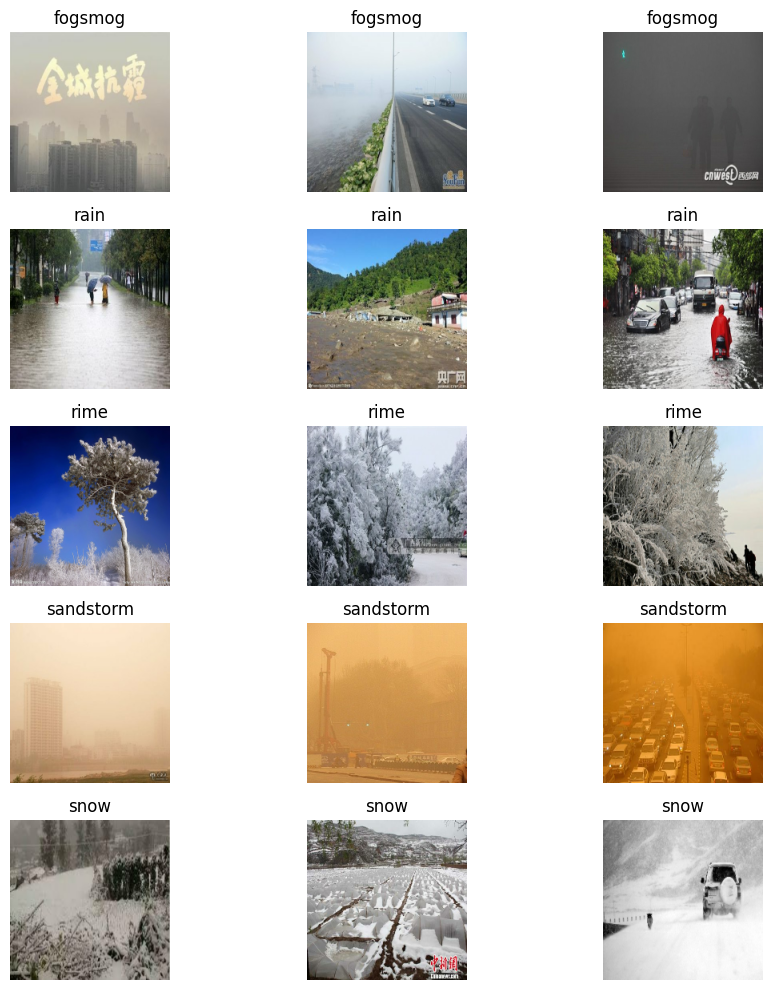

In [7]:
import matplotlib.pyplot as plt

# Define the number of images to plot for each class
num_images_per_class = 3

# Initialize a figure to plot the images
fig, axes = plt.subplots(len(classes), num_images_per_class, figsize=(10,10))

# Iterate over each class
for i, cls in enumerate(classes):
    # Find indices of examples belonging to the current class
    class_indices = np.where(np.argmax(y_train, axis=1) == i)[0]
    # Select a few examples from the current class
    selected_indices = np.random.choice(class_indices, num_images_per_class, replace=False)
    # Plot the selected images for the current class
    for j, idx in enumerate(selected_indices):
        img = x_train[idx]  # Assuming X_train contains your image data
        axes[i, j].imshow(img)
        axes[i, j].set_title(cls)
        axes[i, j].axis('off')


plt.tight_layout()
plt.show()


<a id = "cell_model"></a>
## 3. AI Model Development

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Flatten
from tensorflow.keras.layers import MaxPooling2D, Activation, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard, Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Nadam, Adadelta
from tensorflow.keras.losses import categorical_crossentropy, binary_crossentropy
from tensorflow.keras import regularizers

In [9]:
def model_2(img_rows, img_cols, channels, num_classes, dense_activation_function="softmax"):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(img_rows, img_cols, channels)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation=dense_activation_function))
    model.summary()
    return model

In [10]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
model_name = 'best_model.keras'
model_checkpoint_callback = ModelCheckpoint(filepath=model_name, monitor='val_accuracy', save_best_only=True, mode='max', verbose=0)

# Combine the callbacks into a list
keras_callbacks = [early_stopping_callback, model_checkpoint_callback]

In [11]:
model = model_2(img_rows=img_rows, img_cols=img_cols, channels=channels, num_classes=5, dense_activation_function="softmax")

/Users/s223042074/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 198, 198, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 313632)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    40,145,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,146,565 (153.15 MB)

 Trainable params: 40,146,565 (153.15 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
              metrics=['accuracy'])

#Other Optimizers that can be used instead of RMSprop
#Adadelta(lr=0.001, rho=0.95, epsilon=1e-07)
#Adadelta(lr=0.05, rho=0.99, epsilon=1e-07)
#Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
#RMSprop(learning_rate=0.001,weight_decay=1e-6)

hist = model.fit(x_train, y_train, 
      batch_size=32,
      epochs=40,
      verbose=2,
      validation_data=(x_test, y_test),
      validation_split=0.2,
      callbacks=keras_callbacks)

Epoch 1/40


2024-04-17 18:57:20.021554: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


69/69 - 23s - 332ms/step - accuracy: 0.3908 - loss: 2.7743 - val_accuracy: 0.5586 - val_loss: 1.2839
Epoch 2/40
69/69 - 22s - 313ms/step - accuracy: 0.4229 - loss: 1.3773 - val_accuracy: 0.5421 - val_loss: 1.2733
Epoch 3/40
69/69 - 21s - 307ms/step - accuracy: 0.4477 - loss: 1.2881 - val_accuracy: 0.5769 - val_loss: 1.0275
Epoch 4/40
69/69 - 21s - 305ms/step - accuracy: 0.4858 - loss: 1.1807 - val_accuracy: 0.7308 - val_loss: 0.8480
Epoch 5/40
69/69 - 21s - 310ms/step - accuracy: 0.5225 - loss: 1.0770 - val_accuracy: 0.6813 - val_loss: 0.8835
Epoch 6/40
69/69 - 21s - 311ms/step - accuracy: 0.5661 - loss: 0.9945 - val_accuracy: 0.7363 - val_loss: 0.7797
Epoch 7/40
69/69 - 20s - 296ms/step - accuracy: 0.5693 - loss: 1.0016 - val_accuracy: 0.6832 - val_loss: 0.7871
Epoch 8/40
69/69 - 21s - 302ms/step - accuracy: 0.6330 - loss: 0.9024 - val_accuracy: 0.7491 - val_loss: 0.7025
Epoch 9/40
69/69 - 21s - 307ms/step - accuracy: 0.6679 - loss: 0.8092 - val_accuracy: 0.7582 - val_loss: 0.6313
Epo

In [13]:
# # load model
# from tensorflow.keras.models import load_model

# # Load the saved model
# model = load_model(model_name)

Train loss: 0.0878
Train accuracy: 0.9821 

Test loss: 0.6554
Test accuracy: 0.7839


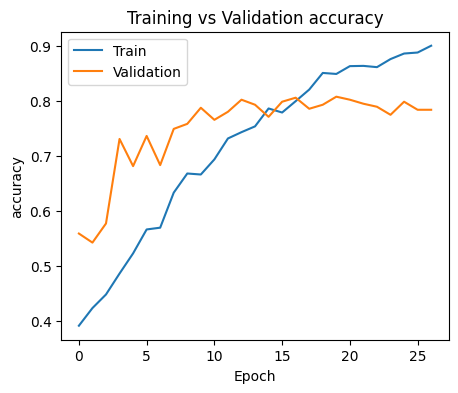

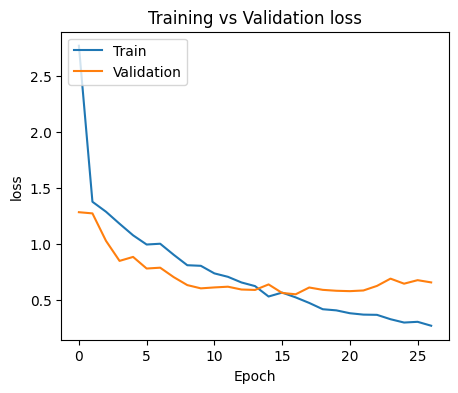

In [14]:
# Evaluate on training data
train_score = model.evaluate(x_train, y_train, verbose=0)
print('Train loss:', round(train_score[0], 4))
print('Train accuracy:', round(train_score[1], 4), '\n')

# Evaluate on test data
test_score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', round(test_score[0], 4))
print('Test accuracy:', round(test_score[1], 4))

import math
def plot_hist(h, xsize=5, ysize=4):
    # Prepare plotting
    fig_size = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = [xsize, ysize]

    # Get training and validation keys
    ks = list(h.keys())
    n2 = math.floor(len(ks)/2)
    train_keys = ks[0:n2]
    valid_keys = ks[n2:2*n2]

    # summarize history for different metrics
    for i in range(n2):
        plt.plot(h[train_keys[i]])
        plt.plot(h[valid_keys[i]])
        plt.title('Training vs Validation '+train_keys[i])
        plt.ylabel(train_keys[i])
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.draw()
        plt.show()

    return

plot_hist(pd.DataFrame(hist.history))

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step
The result of Kappa is : 0.73
The result of the classification report is: 
                precision    recall  f1-score   support

     fogsmog       0.78      0.85      0.81       102
        rain       0.80      0.79      0.79       107
        rime       0.75      0.76      0.75       104
   sandstorm       0.88      0.90      0.89       115
        snow       0.71      0.64      0.67       118

    accuracy                           0.78       546
   macro avg       0.78      0.79      0.78       546
weighted avg       0.78      0.78      0.78       546



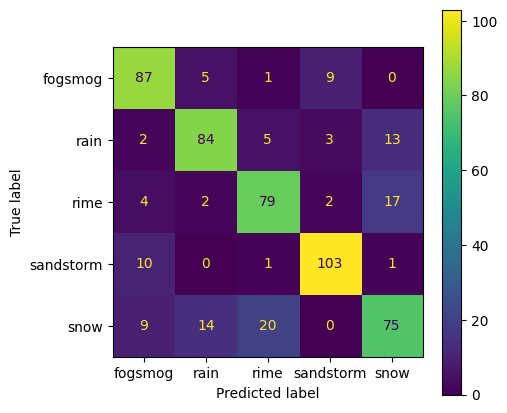

In [15]:
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score

# Make predictions on the test set
y_pred = model.predict(x_test)

# Convert the predicted labels to continuous-multioutput format
y_pred_continuous = np.round(y_pred)

# Convert the predicted labels to multiclass format
y_pred_multiclass = np.argmax(y_pred, axis=1)
y_test_multiclass = np.argmax(y_test, axis=1)

# Calculate the kappa score
kappa = cohen_kappa_score(y_test_multiclass, y_pred_multiclass)
print("The result of Kappa is :", round(kappa, 3))

# Generate the classification report
report = classification_report(y_test_multiclass, y_pred_multiclass, target_names= classes)

# Print the report
print("The result of the classification report is: \n ",report)

import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(
    y_test_multiclass,
    y_pred_multiclass)

# Create a ConfusionMatrixDisplay object
display = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=classes)

# Create a figure with a larger size
fig = plt.figure(figsize=(5, 5))

# Create a subplot within the figure
ax = fig.subplots()

# Plot the confusion matrix as a heatmap
display.plot(ax=ax)

# Show the plot
plt.show()

Print sample predictions

In [16]:
def plot_images(ims, figsize=(10,10), cols=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        if (ims.shape[-1] != 3):
            ims = ims = ims[:,:,:,0]
    f = plt.figure(figsize=figsize)
    rows=len(ims)//cols if len(ims) % cols == 0 else len(ims)//cols + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


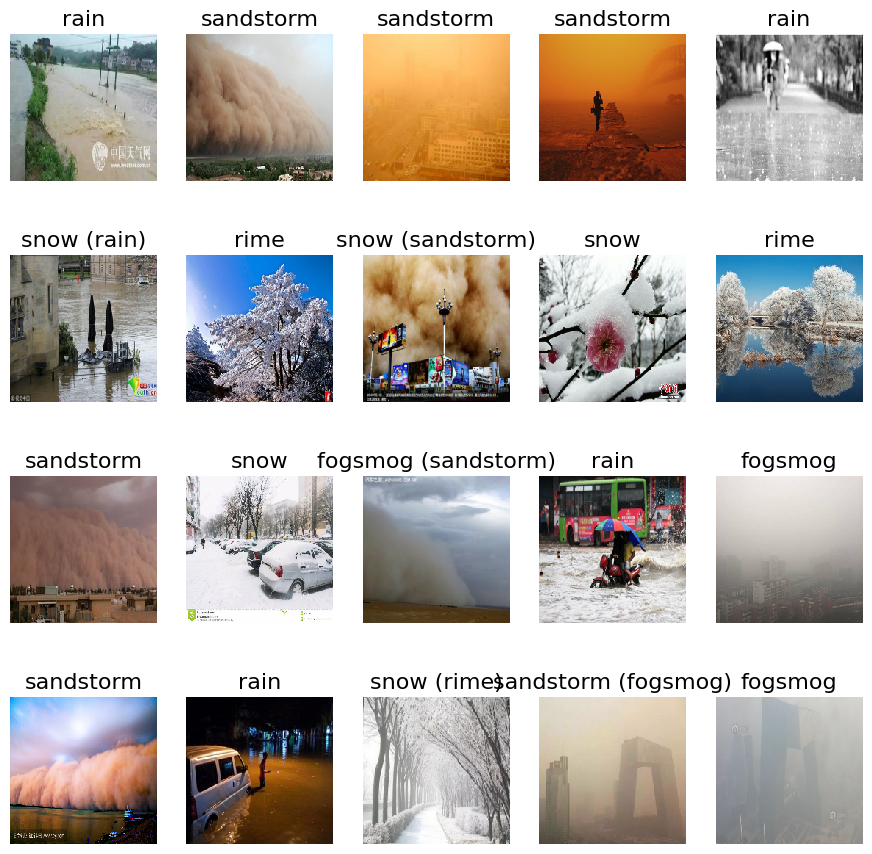

In [17]:
img_range = range(20)
imgs = x_test[img_range]
true_labels = [classes[np.argmax(x)] for x in y_test[img_range]]
predictions = model.predict(imgs.reshape(len(img_range), img_rows, img_cols, channels))
pred_labels = [classes[np.argmax(x)] for x in predictions]
titles = [pred_labels[x]+('' if true_labels[x] == pred_labels[x] else ' ('+true_labels[x]+')') for x in img_range]
plot_images(imgs, cols=5, figsize=(11,11), titles=titles)

<a id = "cell_report"></a>
## 4. Experiments Report